In [11]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [12]:
from google.colab import files
uploaded = files.upload()

# Load the uploaded file into a pandas DataFrame
data = pd.read_csv('financial_portfolio_data.csv')
print(data.head())

Saving financial_portfolio_data.csv to financial_portfolio_data.csv
         Date    Asset   Price
0  2023-07-10   Bond B  385.64
1  2023-03-03  Stock B  297.20
2  2023-09-13   Bond B   75.98
3  2023-01-07   Bond B  356.34
4  2023-06-04  Stock A  260.05


In [13]:
# Loading the dataset
data = pd.read_csv('/content/financial_portfolio_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

In [14]:
# Normalize the data (MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
data['Price'] = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

**Lagged Features**

Lagged features are variables that capture the past values of a time series to be used as predictors for forecasting future values. They help in capturing temporal dependencies, which are crucial for time series analysis.

For example:

Lag 1: The value of the time series one time step before the current value.

Lag 2: The value two time steps before, and so on.

These features transform a time series into a supervised learning problem, where the input features are lagged values, and the target is the future value.

In [15]:
# Prepare lagged features (sequences)
def create_sequences(dataset, time_steps=3):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:i + time_steps, 0])  # Past 'time_steps' prices
        y.append(dataset[i + time_steps, 0])   # Next price
    return np.array(X), np.array(y)

For a time series
𝑋
𝑡
X
t
​
  where
𝑡
t represents time, lagged features can be represented as:

**Lag**
𝑘
(
𝑋
𝑡
)
=
𝑋
𝑡
−
𝑘


Where:

𝑘
k is the lag period (how many steps back).

𝑋
𝑡
  is the value of the time series at time
t.

In [16]:
# Filter data for one asset (e.g., 'Stock A')
asset_data = data[data['Asset'] == 'Stock A']['Price'].values.reshape(-1, 1)
time_steps = 3
X, y = create_sequences(asset_data, time_steps)

# Reshape X for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

In [17]:
# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3894
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3715 
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3544 
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3229 
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3014 
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2963 
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2823 
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2586 
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2518 
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2339 
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2065 
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2011 
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1895 
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1819 
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1635 
Epoch 16/50
3/3 ━━━━━━━━━━━━━━━━━━━

In [19]:
# Make predictions on test data
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_pred_scaled = scaler.inverse_transform(y_pred)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Combine predictions with actual values for comparison
results = pd.DataFrame({'Actual': y_test_scaled.flatten(), 'Predicted': y_pred_scaled.flatten()})
print(results.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
   Actual   Predicted
0  298.43  323.952637
1  488.47  324.916382
2  468.90  327.204254
3  422.02  337.508240
4  414.13  367.439484


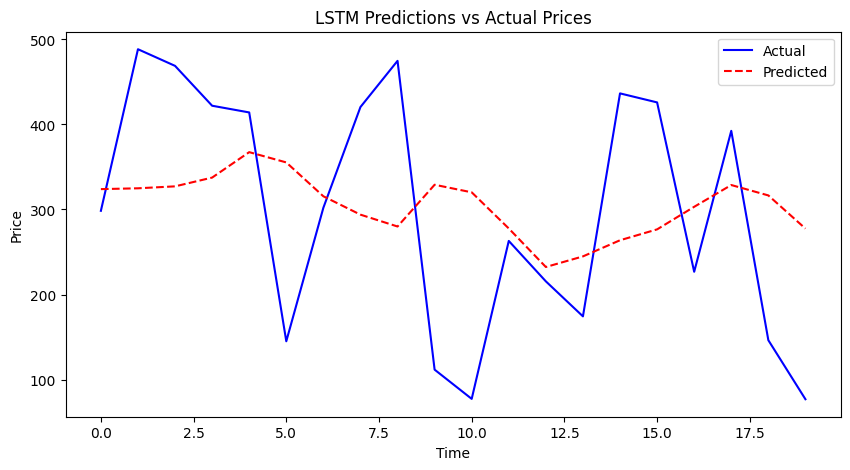

In [20]:
# Plot the predictions vs actual
plt.figure(figsize=(10, 5))
plt.plot(results['Actual'], label='Actual', color='blue')
plt.plot(results['Predicted'], label='Predicted', color='red', linestyle='--')
plt.title('LSTM Predictions vs Actual Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
